In [53]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
from scipy.stats import poisson
import numpy as np

In [157]:
pd.set_option("display.max_columns", None)

In [24]:
lof_df = pd.read_csv(file_dir + "fake_transcript_variants_v4_lof_HC_filtered_unint.gz", usecols = ["Gene", "Chrom", "Pos"], sep = "\t")

In [39]:
file_dir = "/net/home/dlee/brca1/data/summary_gnomAD/lof/"
filename = "fake_transcript_variants_v4_lof_HC_filtered_unint_roulette_covcor.tsv"
df = pd.read_csv(file_dir + filename, sep = "\t")

filename_pergene = "fake_transcript_variants_v4_lof_HC_filtered_unint_roulette_covcor_pergene.tsv"
df_pergene = pd.read_csv(file_dir + filename_pergene, sep = "\t")

In [38]:
df[df["Gene"]== "ENSG00000005059"].sort_values("expected")

,Unnamed: 0,Gene,median,AN,AC,interp_dist,mu,polymorphic,syn_AN,syn_AN_nfe,syn_median,median_int,rate_per_gen,poisson_lambda_fit,p,median_log,scaling_factor,expected
3188707,3188707,ENSG00000005059,0.0,10610.0,1.0,0,0.094,1,212146.91018,95149.149701,35.730539,0.000000,9.539313e-09,0.126243,0.881401,-inf,-inf,-inf
3188728,3188728,ENSG00000005059,31.0,246200.0,5.0,0,1.514,1,212146.91018,95149.149701,35.730539,31.000000,1.536438e-07,2.033313,0.130901,1.491362,1.0,0.130901
844060,844060,ENSG00000005059,0.0,NaN,0.0,-1,0.250,0,212146.91018,95149.149701,35.730539,35.730539,2.537051e-08,0.335752,0.714800,1.553040,1.0,0.714800
844142,844142,ENSG00000005059,32.0,NaN,0.0,-1,0.198,0,212146.91018,95149.149701,35.730539,35.730539,2.009345e-08,0.265915,0.766504,1.553040,1.0,0.766504
844162,844162,ENSG00000005059,29.0,NaN,0.0,-1,0.186,0,212146.91018,95149.149701,35.730539,35.730539,1.887566e-08,0.249799,0.778957,1.553040,1.0,0.778957
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
844076,844076,ENSG00000005059,37.0,NaN,0.0,-1,0.013,0,212146.91018,95149.149701,35.730539,35.730539,1.319267e-09,0.017459,0.982692,1.553040,1.0,0.982692
844178,844178,ENSG00000005059,45.0,NaN,0.0,-1,0.013,0,212146.91018,95149.149701,35.730539,35.730539,1.319267e-09,0.017459,0.982692,1.553040,1.0,0.982692
844177,844177,ENSG00000005059,45.0,NaN,0.0,-1,0.013,0,212146.91018,95149.149701,35.730539,35.730539,1.319267e-09,0.017459,0.982692,1.553040,1.0,0.982692
844129,844129,ENSG00000005059,40.0,NaN,0.0,-1,0.013,0,212146.91018,95149.149701,35.730539,35.730539,1.319267e-09,0.017459,0.982692,1.553040,1.0,0.982692


In [45]:
# number of genes with 0 expected
len(df_pergene[df_pergene["expected"] == 0])

304

In [46]:
df_pergene = df_pergene[df_pergene["expected"] != 0]

<AxesSubplot:xlabel='expected', ylabel='polymorphic'>

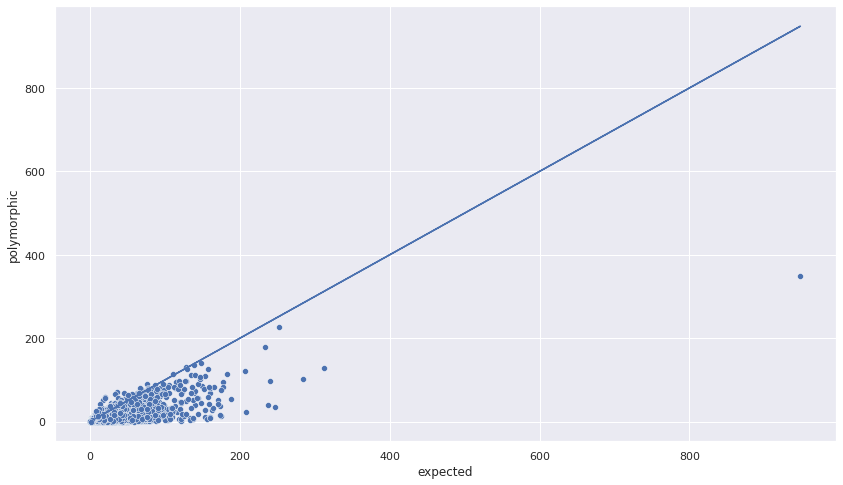

In [47]:
plt.subplots(figsize=(14, 8))

x = df_pergene["expected"]
plt.plot(x, x)

sns.scatterplot(data=df_pergene, x="expected", y="polymorphic")

In [118]:
iterator = 0

def get_upper_bound(gene, count, expected):
    
#     if iterator % 100 == 0:
#         print(iterator)
    
    lambd_list = np.linspace(0,2,2001)
    pmf = [poisson.pmf(k, lambd * expected) for lambd in lambd_list]
    dist_df = pd.DataFrame(zip(lambd_list, pmf), columns = ["Lambda", "pmf"])
    
    dist_df["pmf"] = dist_df["pmf"]/dist_df["pmf"].sum()
    dist_df["cdf"] = np.cumsum(dist_df["pmf"])
    
    dist_df_upper = dist_df[(dist_df["cdf"] < 0.95)]
    
    upper_bound = dist_df_upper[dist_df_upper["cdf"] == dist_df_upper["cdf"].max()]
    
    return upper_bound

In [120]:
df_pergene["upper_oe_lof"] = [get_upper_bound(gene, count, expected) for gene, count, expected in 
                                                zip(df_pergene["Gene"] , df_pergene["polymorphic"], df_pergene["expected"])]

In [129]:
df_pergene.to_csv(file_dir + "LOEUF_roulette.tsv", sep = "\t", index = None)

## Analyze result of LOEUF

In [149]:
## load LOEUF scores

data_dir = "/net/home/dlee/brca1/data/"

loeuf = pd.read_csv(data_dir + "lof/supplementary_dataset_11_full_constraint_metrics.tsv", sep = "\t")

loeuf = loeuf[loeuf["canonical"] == True]

loeuf.rename({"gene_id": "Gene"}, axis = 1, inplace = True)

In [150]:
## load AD AR genes

adar_dir = "/net/home/dlee/brca1/data/clinical/AD_AR_fromDan_revised/"

ad_hq = pd.read_csv(adar_dir +"AD/CGD_AD_HQ_ENSG.tsv", sep = "\t")

ad_hq["type"] = "AD"

In [159]:
df_pergene_merged = df_pergene.merge(loeuf[["Gene", "oe_lof_upper", "obs_lof", "exp_lof"]], how = "inner", on = "Gene", suffixes=('_Roulette', '_gnomAD'))

df_pergene_merged["oe_lof_upper_gnomAD"] = df_pergene_merged["oe_lof_upper"]
df_pergene_merged["oe_lof_upper_roulette"] = df_pergene_merged["upper_oe_lof"]

In [161]:
#make decile
df_pergene_merged["oe_lof_upper_gnomAD_decile"] = pd.qcut(df_pergene_merged["oe_lof_upper_gnomAD"], 10, labels = False)
df_pergene_merged["oe_lof_upper_roulette_decile"] = pd.qcut(df_pergene_merged["oe_lof_upper_roulette"], 10, labels = False)

In [162]:
df_pergene_merged = df_pergene_merged.merge(ad_hq[["Gene", "type"]], how = "left", on = "Gene")

ad_len = len(df_pergene_merged[df_pergene_merged["type"] =="AD"])
print(ad_len)

225


In [163]:
for decile in range(10):
    print(decile)
    
    shet_dec = df_pergene_merged[df_pergene_merged["oe_lof_upper_gnomAD_decile"] == decile]
    print(len(shet_dec[shet_dec["type"] == "AD"])/ad_len)
    
    shet_dec = df_pergene_merged[df_pergene_merged["oe_lof_upper_roulette_decile"] == decile]
    print(len(shet_dec[shet_dec["type"] == "AD"])/ad_len)

0
0.48444444444444446
0.27555555555555555
1
0.18666666666666668
0.14222222222222222
2
0.10222222222222223
0.17333333333333334
3
0.06666666666666667
0.10222222222222223
4
0.057777777777777775
0.07555555555555556
5
0.035555555555555556
0.08
6
0.022222222222222223
0.04888888888888889
7
0.017777777777777778
0.035555555555555556
8
0.017777777777777778
0.057777777777777775
9
0.008888888888888889
0.008888888888888889


In [166]:
df_pergene_merged[df_pergene_merged["type"] =="AD"][["expected", "polymorphic", "obs_lof", "exp_lof"]]

,expected,polymorphic,obs_lof,exp_lof
15,26.101204,14,14.0,43.8340
80,75.576558,2,3.0,118.3500
151,19.770408,0,0.0,27.8800
163,21.465862,1,1.0,28.1270
203,173.428501,16,18.0,149.3700
...,...,...,...,...
14906,5.127403,2,2.0,8.6129
15030,9.239721,14,14.0,10.6810
15198,7.119396,2,2.0,10.2850
15816,40.564748,2,2.0,50.9870
